In [1]:
import sys
sys.path.append('../')
sys.path.append('../WD_models')

### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from astropy.table import Table, Column, MaskedColumn, join
from astropy.table import vstack

from tqdm import tqdm
import pandas as pd
import WD_models

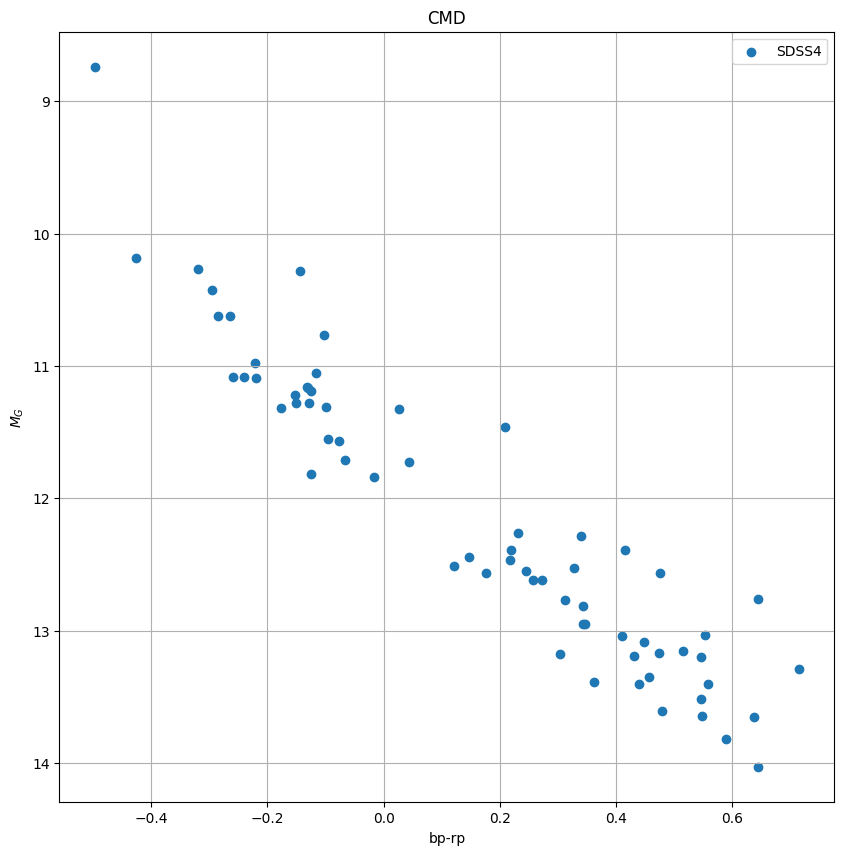

In [2]:
c1 = Table.read('data/03_wd_rv.fits')
c2 = Table.read('data/02_photometry.fits')

#c15 = Table.read('data/sdss5/sdss5_catalog_photo.fits')
#c25 = Table.read('data/sdss5/sdss5_catalog_rvs.fits')

plt.figure(figsize=(10,10))

plt.scatter(c1['wd_bp_rp'], c1['wd_m_g'], label='SDSS4')
#plt.scatter(c25['wd_bp_rp'], c25['wd_m_g'], label='SDSS5')

plt.grid()
plt.ylabel(r'$M_G$')
plt.xlabel(r'bp-rp')
plt.title(r'CMD')
plt.gca().invert_yaxis()
xmin, xmax = plt.xlim()

plt.legend()
plt.show()

catalog = join(c1, c2, keys='wd_source_id', join_type='inner')
catalog['program'] = [4 for i in range(len(catalog))]

#catalog2 = join(c15, c25, keys='wd_source_id', join_type='inner')
#catalog2['program'] = [5 for i in range(len(catalog2))]

#catalog2.remove_columns(['wd_pos_1_1','wd_pos_1_2', 'wd_pos_2_1','wd_pos_2_2'])
#catalog = vstack([catalog, catalog2])

In [3]:
model = WD_models.load_model('f', 'f', 'f', 'H')
HR_grid = (-0.6, 1.25, 0.002, 10, 15, 0.01)
#model = WD_models.load_model('be', 'be', 'be', 'H', HR_grid=HR_grid)
extent = (HR_grid[0], HR_grid[1], HR_grid[3], HR_grid[4])

In [4]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_15981/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_15981/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_15981/1503571099.py:19: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


In [5]:
#catalog[['wd_coords', 'clean', 'insideMask', 'converged', 'reliable_dist']].pprint(100,100)

np.all([catalog['program'] == 5], axis = 0)
clean = np.logical_or(catalog['clean'], np.all([catalog['program'] == 5], axis = 0))

66
20.85055144360322
11.56531586241371


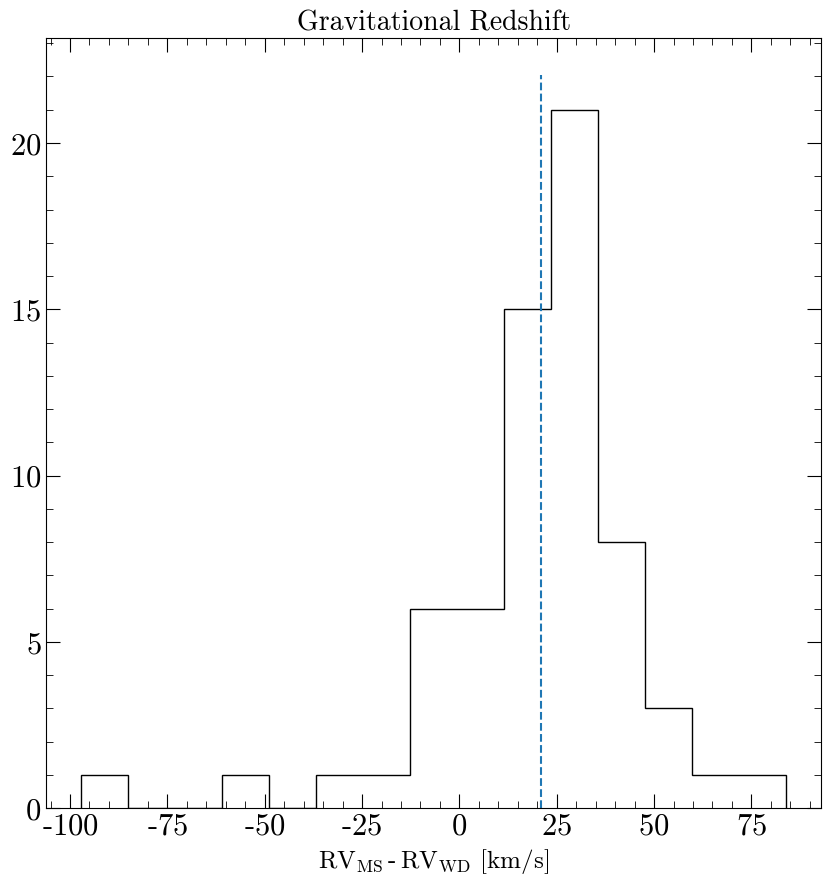

In [6]:
plt.figure(figsize=(10,10))
plt.style.use('./stefan.mplstyle')

#plt.grid()
plt.hist(catalog[catalog['g_redshift'] < 1000]['g_redshift'], bins = 15, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog[catalog['g_redshift'] < 1000]['g_redshift']), ymin, ymax, linestyles='dashed')
plt.title('Gravitational Redshift', fontsize=20)
plt.xlabel(r'$RV_{MS} - RV_{WD}$ $[km/s]$', fontsize=18)

print(len(catalog))
print(np.mean(catalog[catalog['g_redshift'] < 1000]['g_redshift']))
print(np.mean(catalog[catalog['g_redshift'] < 1000]['eg_redshift']))

plt.savefig('figs/fig1_vg_hist.pdf')

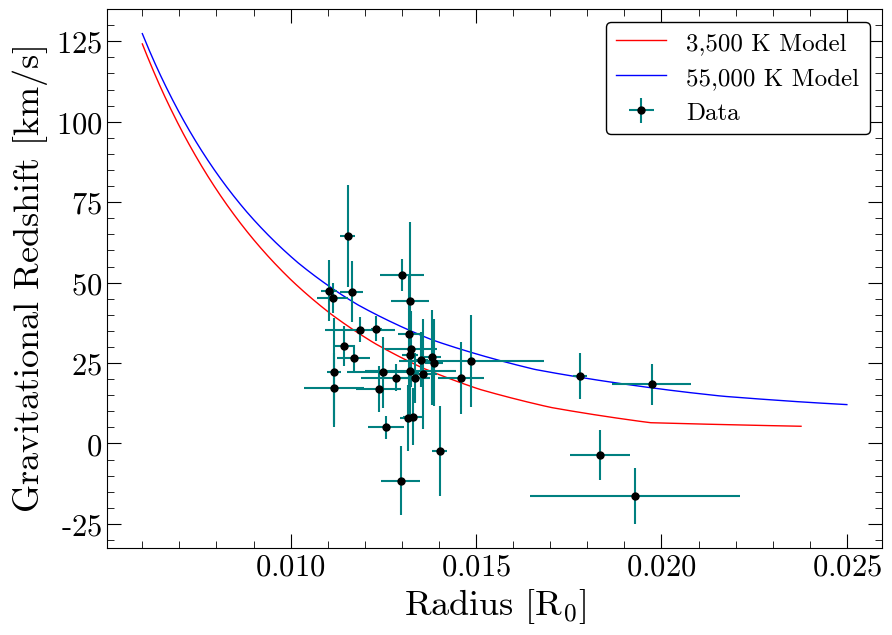

In [7]:
''' GENERATE MASK FROM FLAGS '''

rechi = np.all([catalog['rechi'] < 5], axis = 0)
redchi = np.all([catalog['redchi'] < 5], axis = 0)

mask = np.all([redchi, rechi, clean], axis = 0)


''' PLOTTING '''

plt.figure(figsize=(10,7))
plt.style.use('./stefan.mplstyle')

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Data', color='black', ecolor = 'teal')

plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.006, 0.025)
#plt.ylim(0, 120)
plt.legend()

plt.savefig('figs/fig3_mr_relation.pdf')
plt.savefig('figs/fig3_mr_relation.png')


#catalog[['wd_catalog_id', 'rv_id', 'radius', 'e_radius', 'g_redshift', 'eg_redshift', 'redchi', 'rechi', 'corv_teff', 'program']][mask].pprint(100, 200)
#catalog[['wd_catalog_id', 'radius', 'e_radius', 'g_redshift', 'eg_redshift', 'redchi', 'rechi', 'program']][~mask].pprint(100, 200)

In [16]:
catalog[['wd_source_id']][~mask].write('data/masked_sourceids.fits', overwrite = True)
catalog[['wd_source_id']][mask].write('data/final_sourceids.fits', overwrite = True)

In [9]:
'''
Note:

For the discussion section I need to look at some of these
outliers and see if there's anything to explain them. Almost
all the science is done in the cells above, so everything 
from here on out is just for sections 3 & 5.
'''

"\nNote:\n\nFor the discussion section I need to look at some of these\noutliers and see if there's anything to explain them. Almost\nall the science is done in the cells above, so everything \nfrom here on out is just for sections 3 & 5.\n"

In [10]:
print(len(catalog[mask]))

35


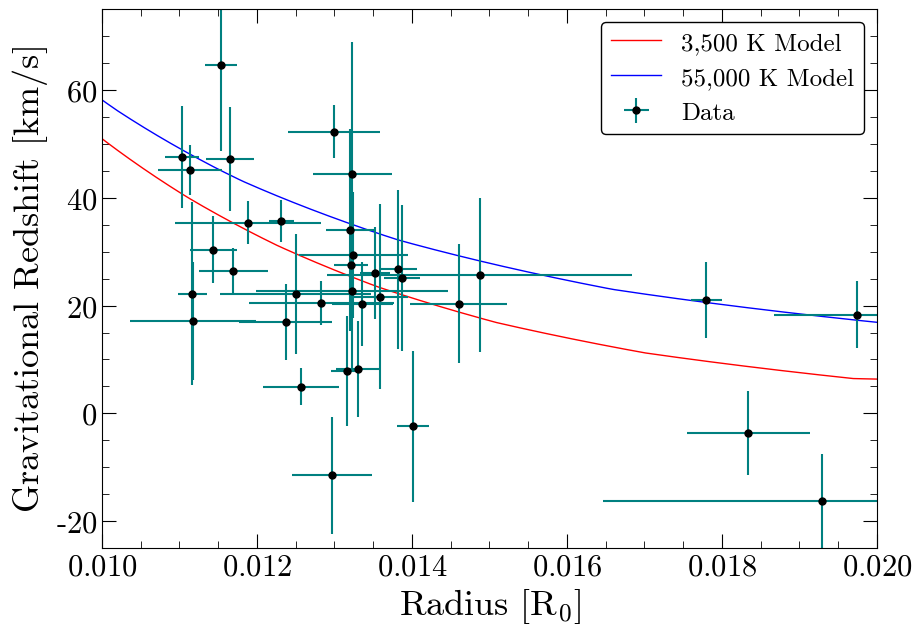

In [15]:
plt.figure(figsize=(10,7))
plt.style.use('./stefan.mplstyle')

i = 496

# Theoretical Tracks

rsuns = np.linspace(0.006,0.025, 1000)

theoretical_rvs = rv_from_radius(rsuns, 3500, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'red', linestyle = '-', label = '3,500 K Model', linewidth = 1)

theoretical_rvs = rv_from_radius(rsuns, 55000, 'f', 'f', 'f')
plt.plot(rsuns, theoretical_rvs, 'blue', label = '55,000 K Model', linewidth = 1)

# Data

#print(catalog['phot_id'][mask].pprint(100,100))

# These are the new arguments that I used
#scatter_kwargs = {"zorder":100}
#error_kwargs = {"lw":.5, "zorder":0}

scatter_kwargs = {}
error_kwargs = {}

#plt.errorbar(catalog['radius'][catalog['phot_id'] == i], catalog['g_redshift'][catalog['phot_id'] == i], xerr = catalog['e_radius'][catalog['phot_id'] == i], yerr=catalog['eg_redshift'][catalog['phot_id'] == i], fmt='o', label = 'Data', color='black', ecolor = 'teal', **error_kwargs)
plt.errorbar(catalog['radius'][mask], catalog['g_redshift'][mask], xerr = catalog['e_radius'][mask], yerr=catalog['eg_redshift'][mask], fmt='o', label = 'Data', color='black', ecolor = 'teal', **error_kwargs)



#for i in range(len(catalog['radius'][mask])):
#    x = catalog['radius'][mask][i]
#    y = catalog['g_redshift'][mask][i]
#    #plt.plot(x, y, 'bo')
#    
#    #if (0.006 < x < 0.025) and (0 < y < 120):
#    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f,' % (catalog['phot_id'][mask][i])), fontsize=11)

plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
plt.xlim(0.01, 0.02)
plt.ylim(-25, 75)
#plt.colorbar()
plt.legend()
plt.savefig('figs/diagnostic.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


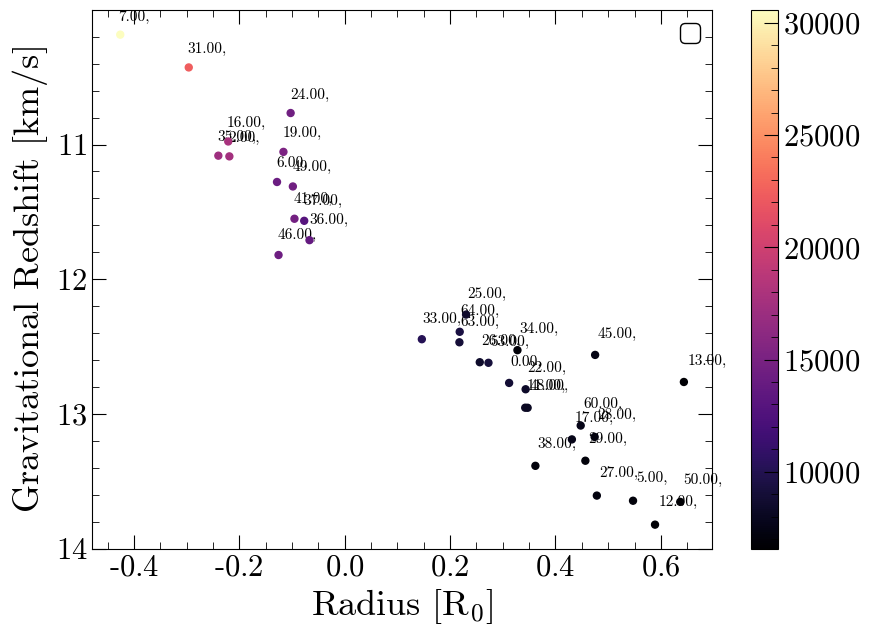

In [12]:
plt.figure(figsize=(10,7))
plt.style.use('./stefan.mplstyle')

# Data

# These are the new arguments that I used
scatter_kwargs = {"zorder":100}
error_kwargs = {"lw":.5, "zorder":0}

plt.scatter(catalog['wd_bp_rp'][mask],catalog['wd_m_g'][mask],c=catalog['phot_teff_1'][mask], **scatter_kwargs)


for i in range(len(catalog['radius'][mask])):
    x = catalog['wd_bp_rp'][mask][i]
    y = catalog['wd_m_g'][mask][i]
    #plt.plot(x, y, 'bo')
    
    #if (0.006 < x < 0.025) and (0 < y < 120):
    plt.text(x * (1 + 0.01), y * (1 - 0.01) , ('%2.2f,' % (catalog['rv_id'][mask][i])), fontsize=11)

plt.xlabel(r'Radius $[R_{0}]$')
plt.ylabel(r'Gravitational Redshift $[km/s]$')
#plt.xlim(0.01, 0.02)
#plt.ylim(-25, 75)
plt.gca().invert_yaxis()

plt.colorbar()
plt.legend()
plt.savefig('plots/cmd.png')

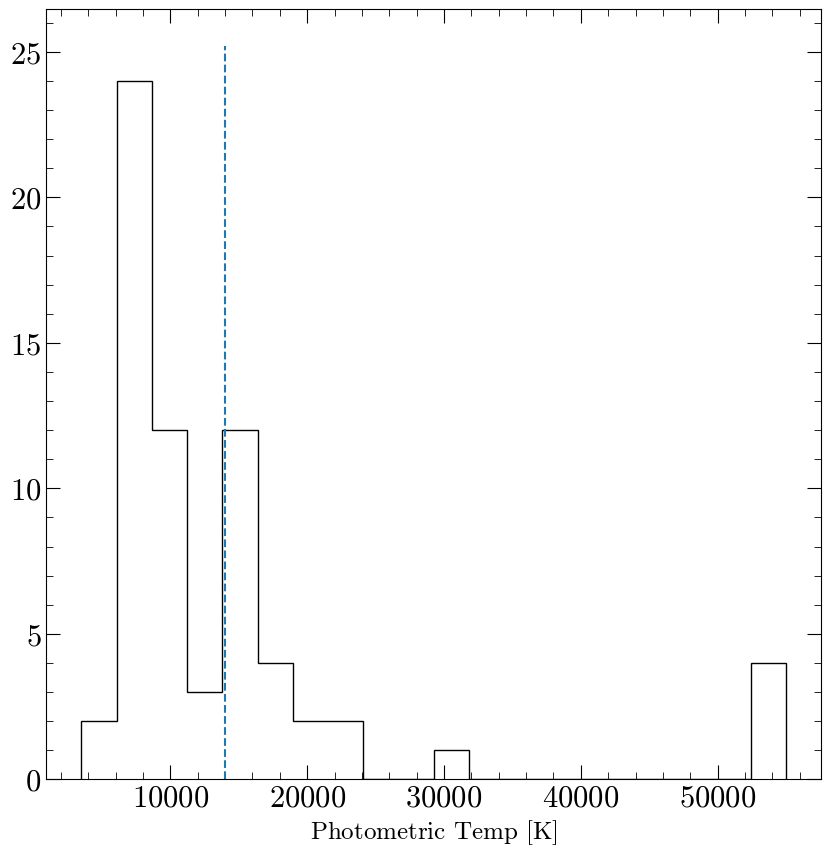

In [13]:
plt.figure(figsize=(10,10))
plt.hist(catalog['phot_teff_1'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['phot_teff_1']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Temp $[K]$', fontsize=18)
plt.savefig('plots/photometry/fin)radius.png')

 **From the above plot, the following stars are not consistent with the predicted relation because they fall below it:**
 
 <img src='spectra/radfits/radius325.0.jpg'>
 <img src='spectra/radfits/radius957.00.jpg'>
 <img src='spectra/radfits/radius29.0.jpg'>
 <img src='spectra/radfits/radius494.0.jpg'>
 <img src='spectra/radfits/radius52.0.jpg'>
 <img src='spectra/radfits/radius547.0.jpg'>
 
 **And one is above it:**
 
 <img src='spectra/radfits/radius163.0.jpg'>
  <img src='spectra/radfits/radius276.0.jpg'>

**From the above plot, the following stars are not consistent with the predicted relation because they fall below it:**

<img src='spectra/corvfits/corvfit24.jpg'>
<img src='spectra/corvfits/corvfit11.jpg'>
<img src='spectra/corvfits/corvfit2.jpg'>
<img src='spectra/corvfits/corvfit22.jpg'>
<img src='spectra/corvfits/corvfit33.jpg'>
<img src='spectra/corvfits/corvfit36.jpg'>

**And one is above it:**
<img src='spectra/corvfits/corvfit7.jpg'>